# **pre-processing**

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import networkx as nx
import nltk
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.metrics.pairwise import cosine_similarity
from nltk.corpus import stopwords
from collections import Counter
from gensim.models import Word2Vec
import gensim.downloader as api
import random


documents = []
authors = []
edges = [] 
test = []

i = 0


edges_path = "/kaggle/input/nlp-cse-uoi-2025/data_new/edgelist.txt"

# Open and process the file
#j = 0
with open(edges_path, 'r') as file:
    for line in file:
        nodes = line.strip().split(',')  
        edges.append((int(nodes[0]), int(nodes[1])))
        i+=1
#        j+=1

#print("preprocessed ",j," edges")

abstract_path = "/kaggle/input/nlp-cse-uoi-2025/data_new/abstracts.txt"

with open(abstract_path, 'r') as file:
    #for line in file
    documents = [line.strip().split('|--|')[1] for line in file if '|--|' in line]
    i+=1


authors_path = "/kaggle/input/nlp-cse-uoi-2025/data_new/authors.txt"

with open(authors_path, 'r') as file:
    for line in file:
        i+=1
        if '|--|' in line:
            author_line = line.strip().split('|--|')[1]
            author_list = [author.strip() for author in author_line.split(',')]
            authors.append(author_list)

test_path = "/kaggle/input/nlp-cse-uoi-2025/data_new/test.txt"

with open(test_path, 'r') as file:
    for line in file:
        i+=1
        t_nodes = line.strip().split(',')  
        test.append((int(t_nodes[0]), int(t_nodes[1])))


print("preprocessed ",i," items")

preprocessed  1337147  items


# **Graph creation**

In [4]:
import networkx as nx

# Add vertices
all_nodes = set([node for edge in edges for node in edge])


G = nx.Graph()
G.add_edges_from(edges)

# # Print info about the graph
# print("Number of nodes:", G.number_of_nodes())
# print("Number of edges:", G.number_of_edges())



# **non existent edges array**

In [5]:
#produces hard non existent edges
from networkx.algorithms.community import greedy_modularity_communities
import random
import networkx as nx
from collections import defaultdict
from multiprocessing import Pool, cpu_count
from tqdm import tqdm
import community as community_louvain

partition = community_louvain.best_partition(G)
# partition: {node_id: community_id}
community_map = defaultdict(list)
for node, comm_id in partition.items():
    community_map[comm_id].append(node)

communities = [nodes for nodes in community_map.values() if len(nodes) >= 2]

KeyboardInterrupt: 

In [ ]:
from multiprocessing import Pool, cpu_count, get_context
def sample_negative_batch(args):
    G_edges, batch_size, communities = args
    sampled_edges = set()
    attempts = 0
    max_attempts = batch_size * 10

    while len(sampled_edges) < batch_size and attempts < max_attempts:
        nodes = random.choice(communities)
        if len(nodes) < 2:
            continue
        n1, n2 = random.sample(nodes, 2)
        if (n1, n2) not in G_edges and (n2, n1) not in G_edges and (n1, n2) not in sampled_edges and (n2, n1) not in sampled_edges:
            sampled_edges.add((n1, n2))
        attempts += 1

    return list(sampled_edges)


def parallel_hard_negatives(G, communities, total_samples, batch_size=10000):
    G_edges = set(G.edges())
    G_edges |= {(b, a) for a, b in G_edges}  # undirected

    num_batches = (total_samples // batch_size) + 1
    args = [(G_edges, batch_size, communities) for _ in range(num_batches)]

    negatives = set()
    with get_context("fork").Pool(cpu_count()) as pool: 
        for batch in tqdm(pool.imap(sample_negative_batch, args), total=num_batches, desc="Sampling hard negatives"):
            for edge in batch:
                if len(negatives) >= total_samples:
                    break
                if edge not in negatives and (edge[1], edge[0]) not in negatives:
                    negatives.add(edge)

    return list(negatives)[:total_samples]
if __name__ == "__main__":
    hard_neg_edges = parallel_hard_negatives(
        G,
        communities,
        total_samples=len(edges), 
        batch_size=10000           
    )

neg_edges = pd.DataFrame(hard_neg_edges)
neg_edges.to_csv("negative_edges.csv", index=False)

nonexistent edges load - shortcut to previous 2 cells

In [6]:
import csv 
import pandas as pd
nonexistent_edges_r= pd.read_csv("/kaggle/input/negative-edges/negative_edges.csv")

In [7]:
nonexistent_edges = nonexistent_edges_r

In [8]:
i = 0
while i<6:
    i+=1
    print(edges[i])
type(nonexistent_edges)

nonexistent_edges = nonexistent_edges_r.values.tolist()
#type(list_from_df)#

(0, 2)
(1, 3)
(1, 5)
(1, 6)
(1, 7)
(1, 9)


In [9]:

Gn = nx.Graph()
Gn.add_edges_from(nonexistent_edges)

for edge in nonexistent_edges:
    Gn.add_nodes_from(edge)


In [10]:
ones = np.ones(len(edges))
zeros = np.zeros(len(nonexistent_edges))

labels = np.concatenate((ones, zeros), axis=None)

node_ids = [i for i in range(len(labels))]


In [11]:
import multiprocessing as mp

stop_words = set(stopwords.words('english'))
stemmer = nltk.stem.PorterStemmer()

words = []
filtered_docs = [] #rinsed out stop words

def clean_text(doc):
    # Lowercase
    doc = doc.lower()
    # Remove non-alphabetic characters
    doc = re.sub(r'[^a-z\s]', '', doc)
    # Tokenize
    tokens = doc.split()
    # Remove stopwords
    tokens = [t for t in tokens if t not in stop_words]
    # Stem tokens
    tokens = [stemmer.stem(t) for t in tokens]
    # Rejoin
    return ' '.join(tokens)

# print(mp.cpu_count())
# print(len(documents))

def batch_clean_text(docs):
    return [clean_text(doc) for doc in docs]

batched_documents = [documents[i:i+50] for i in range(0, len(documents), 50)]

if __name__ == "__main__":
    with mp.Pool(processes=4) as pool:
        batched_cleaned = list(pool.imap_unordered(batch_clean_text, batched_documents))
    # flatten the list
    cleaned_documents = [doc for batch in batched_cleaned for doc in batch]


In [13]:
#dtm creation
import multiprocessing 
from sklearn.feature_extraction.text import HashingVectorizer, TfidfTransformer
import numpy as np
from tqdm import tqdm

cleaned_documents = documents

# cleaning function to join tokens and convert all tokens to strings
def preprocess(doc):
    if isinstance(doc, list):
        return ' '.join(str(token) for token in doc)
    else:
        return str(doc)

# multiprocessing to preprocess documents in parallel with progress bar
def preprocess_documents(docs, num_workers=1):
    with multiprocessing.Pool(num_workers) as pool:
        cleaned = list(tqdm(pool.imap(preprocess, docs), total=len(docs), desc="Preprocessing"))
    return cleaned

# Batch-wise vectorization using HashingVectorizer + TfidfTransformer with progress bar
def batch_vectorize(docs, batch_size=1000):
    vectorizer = HashingVectorizer(n_features=5000, alternate_sign=False)
    transformer = TfidfTransformer()
    dtm_batches = []

    for i in tqdm(range(0, len(docs), batch_size), desc="Vectorizing"):
        batch_docs = docs[i:i+batch_size]
        X_batch = vectorizer.transform(batch_docs)
        tfidf_batch = transformer.fit_transform(X_batch)
        dtm_batches.append(tfidf_batch)

    dtm_total = np.vstack([batch.toarray() for batch in dtm_batches])
    return dtm_total

num_cpus = 1 #

print(f"Preprocessing with {num_cpus} CPU cores...")
cleaned_documents = preprocess_documents(cleaned_documents, num_workers=num_cpus)

print("Vectorizing in batches...")
dtm = batch_vectorize(cleaned_documents, batch_size=1000)

print("Done! dtm shape:", dtm.shape)


Preprocessing with 1 CPU cores...


Preprocessing: 100%|██████████| 138499/138499 [01:22<00:00, 1682.14it/s]


Vectorizing in batches...


Vectorizing: 100%|██████████| 139/139 [00:15<00:00,  9.12it/s]


Done! dtm shape: (138499, 5000)


# **feature matrix**

In [14]:
import os
import pandas as pd
from joblib import Parallel, delayed
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm

# ↓↓↓ Limit CPU overuse from BLAS (prevents hidden parallel threads)
os.environ["OMP_NUM_THREADS"] = "1"

positive_edges = list(edges)
negative_edges = list(nonexistent_edges)


# Global variables to avoid memory duplication


# def init_globals(graph, pagerank_list, author_list, tfidf_matrix): #useless?
#     global GRAPH, PAGERANK, AUTHORS, DTM 

#     GRAPH = graph
#     AUTHORS = author_list
#     DTM = tfidf_matrix
#     PAGERANK = {node: score for node, score in zip(graph.nodes(), pagerank_list)}


# On-demand cosine similarity
def compute_pairwise_similarity(i, j, dtm_matrix):
    return cosine_similarity(dtm_matrix[i], dtm_matrix[j])[0, 0]


def compute_author_overlap(id1, id2, authors_list):
    authors1 = set(authors_list[id1]) if isinstance(authors_list[id1], list) else set()
    authors2 = set(authors_list[id2]) if isinstance(authors_list[id2], list) else set()
    return len(authors1 & authors2)


def extract_edge_features_wrapper(edge, label, graph, pagerank_dict, authors_list, dtm_matrix):
    try:
        id1, id2 = edge

        # Basic validity checks
        if id1 not in graph or id2 not in graph:
            return None

        text_similarity = compute_pairwise_similarity(id1, id2, dtm_matrix)
        author_overlap = compute_author_overlap(id1, id2, authors_list)

        degree_u = graph.degree(id1)
        degree_v = graph.degree(id2)
        pagerank_u = pagerank_dict.get(id1, 0)
        pagerank_v = pagerank_dict.get(id2, 0)

        neighbors_u = set(graph.neighbors(id1))
        neighbors_v = set(graph.neighbors(id2))
        union = neighbors_u | neighbors_v
        intersection = neighbors_u & neighbors_v
        jaccard = len(intersection) / len(union) if union else 0
        common_neighbors = len(intersection)
        adamic_adar = sum(1 / np.log(graph.degree(n)) for n in intersection if graph.degree(n) > 1)
        abs_degree_diff = abs(degree_u - degree_v)
        abs_pagerank_diff = abs(pagerank_u - pagerank_v)
        combined_score = jaccard * text_similarity
        preferential_attachment = degree_u * degree_v

        return [
            id1, id2,
            degree_u, degree_v,
            pagerank_u, pagerank_v,
            jaccard,
            text_similarity,
            author_overlap,
            common_neighbors,
            adamic_adar,
            abs_degree_diff,
            abs_pagerank_diff,
            combined_score,
            preferential_attachment,
            label
        ]
    except Exception as e:
        print(f"Error processing edge {edge}: {e}")
        return None

def init_pipeline(graph, pagerank_list, authors_list, cleaned_documents):
    pagerank_dict = {node: score for node, score in zip(graph.nodes(), pagerank_list)}
    vectorizer = TfidfVectorizer(max_features=5000)
    dtm = vectorizer.fit_transform(cleaned_documents)
    return graph, pagerank_dict, authors_list, dtm

def pipeline_process_edges(positive_edges, negative_edges, graph, pagerank_dict, authors_list, dtm_matrix, chunk_size=500, n_jobs=4):
    pos_samples = process_edges_in_chunks(positive_edges, 1, graph, pagerank_dict, authors_list, dtm_matrix, chunk_size, n_jobs)
    neg_samples = process_edges_in_chunks(negative_edges, 0, graph, pagerank_dict, authors_list, dtm_matrix, chunk_size, n_jobs)
    return pos_samples + neg_samples

def process_edges_in_chunks(edges, label, graph, pagerank_dict, authors_list, dtm_matrix, chunk_size=500, n_jobs=1):
    all_results = []
    for i in tqdm(range(0, len(edges), chunk_size), desc="Processing chunks"):
        chunk = edges[i:i + chunk_size]
        results = Parallel(n_jobs=n_jobs)(
            delayed(extract_edge_features_wrapper)
               (edge, label, graph, pagerank_dict, authors_list, dtm_matrix
            )
            for edge in chunk
        )
        all_results.extend([r for r in results if r is not None])
    return all_results

def samples_to_X_y(samples):
    samples = [s for s in samples if s is not None]
    X = np.array([row[2:-1] for row in samples], dtype=float)
    y = np.array([row[-1] for row in samples], dtype=int)
    return X, y
    

In [15]:
authors_list = authors

import networkx as nx

# 1. Compute pagerank for G and Gn
pagerank_dict_G = nx.pagerank(G)
pagerank_dict_Gn = nx.pagerank(Gn)

# 2. Assume cleaned_documents is in order of node index

# 3. TF-IDF matrix
vectorizer = TfidfVectorizer(max_features=5000)
dtm = vectorizer.fit_transform(cleaned_documents)

# **split test-train sets & scaling**

In [16]:
# Process 100 positive edges from G
positive_test_samples = process_edges_in_chunks(
    edges=positive_edges,
    label=1,
    graph=G,
    pagerank_dict=pagerank_dict_G,
    authors_list=authors_list,
    dtm_matrix=dtm,
    chunk_size=50,
    n_jobs=1
)

# Process 100 negative edges from Gn
negative_test_samples = process_edges_in_chunks(
    edges=negative_edges,
    label=0,
    graph=Gn,
    pagerank_dict=pagerank_dict_Gn,
    authors_list=authors_list,
    dtm_matrix=dtm,
    chunk_size=50,
    n_jobs=1
)

# Combine and inspect
all_test_samples = positive_test_samples + negative_test_samples
print(f"Got {len(all_test_samples)} total feature rows from test chunks")


Processing chunks: 100%|██████████| 17774/17774 [13:40<00:00, 21.67it/s] 

Got 1980647 total feature rows from test chunks


In [17]:
X, y = samples_to_X_y(all_test_samples)

In [18]:
from sklearn.model_selection import train_test_split

# all_samples = positive_samples + negative_samples

# X, y = samples_to_X_y(all_samples)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


In [24]:
import gc
gc.collect()

0

In [19]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# **prediction & evaluation**


========== Training Logistic Regression ==========


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


              precision    recall  f1-score   support

           0       0.89      0.97      0.92    177739
           1       0.97      0.90      0.93    218391

    accuracy                           0.93    396130
   macro avg       0.93      0.93      0.93    396130
weighted avg       0.93      0.93      0.93    396130

ROC AUC: 0.9745
Log Loss: 0.2094


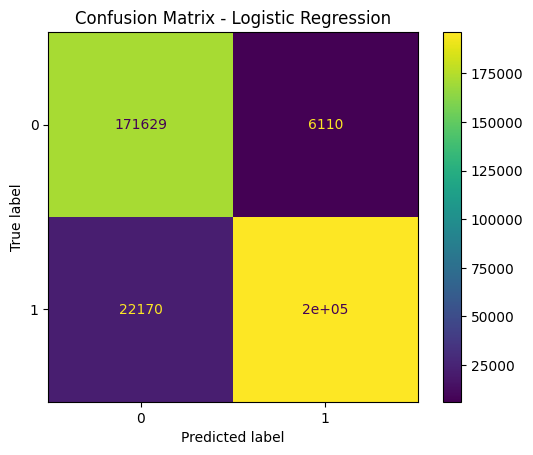


========== Training Random Forest ==========
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    177739
           1       0.99      0.97      0.98    218391

    accuracy                           0.98    396130
   macro avg       0.98      0.98      0.98    396130
weighted avg       0.98      0.98      0.98    396130

ROC AUC: 0.9976
Log Loss: 0.0578


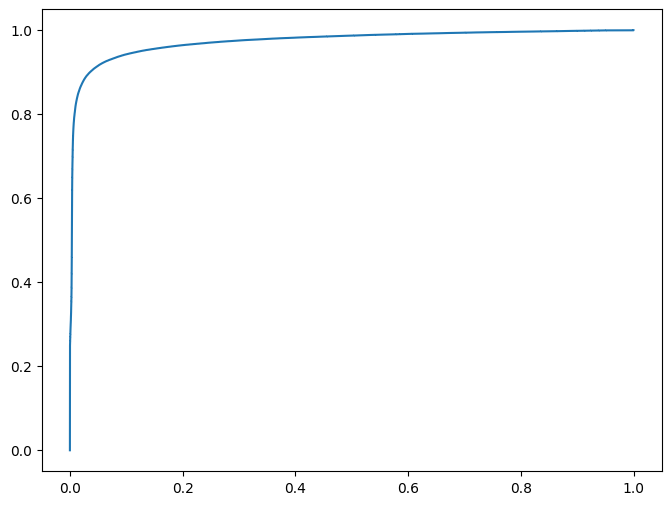

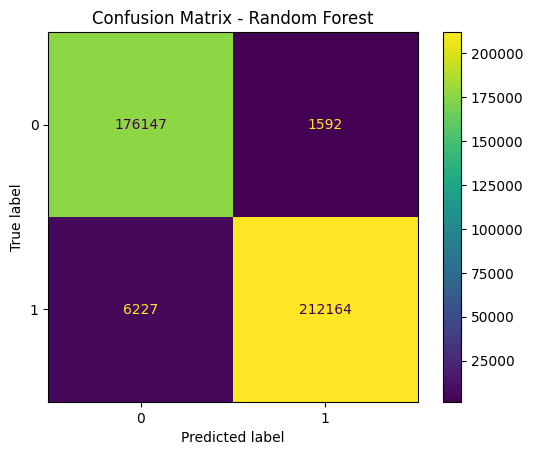


========== Training MLP Neural Net ==========
              precision    recall  f1-score   support

           0       0.98      0.99      0.98    177739
           1       0.99      0.98      0.99    218391

    accuracy                           0.99    396130
   macro avg       0.99      0.99      0.99    396130
weighted avg       0.99      0.99      0.99    396130

ROC AUC: 0.9984
Log Loss: 0.0408


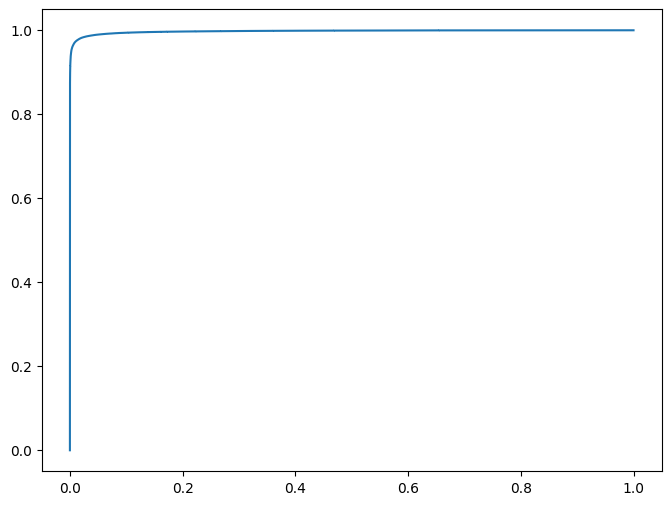

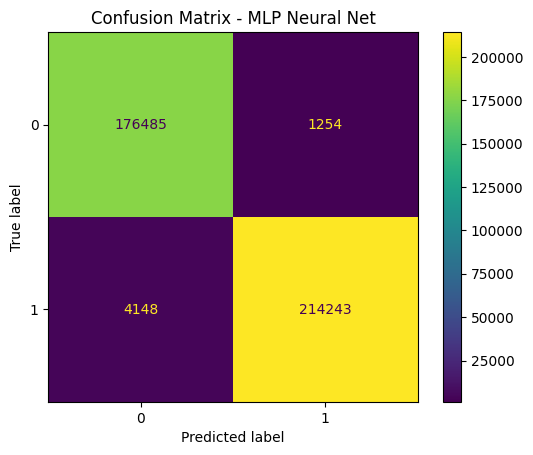


========== Training Gradient Boosting ==========
              precision    recall  f1-score   support

           0       0.95      0.98      0.97    177739
           1       0.98      0.96      0.97    218391

    accuracy                           0.97    396130
   macro avg       0.97      0.97      0.97    396130
weighted avg       0.97      0.97      0.97    396130

ROC AUC: 0.9947
Log Loss: 0.0846


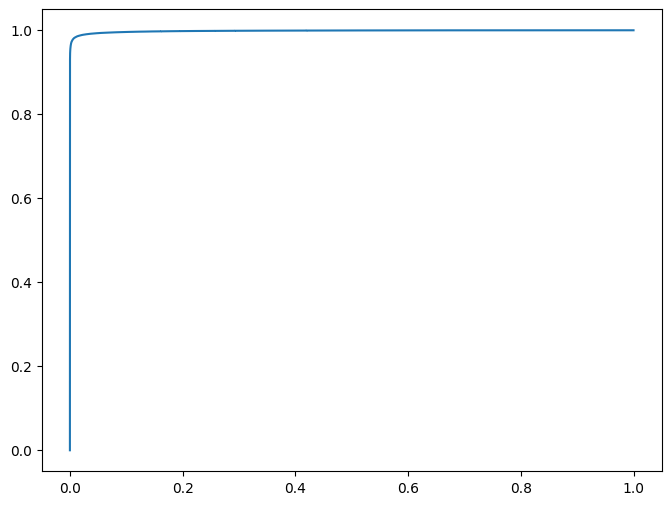

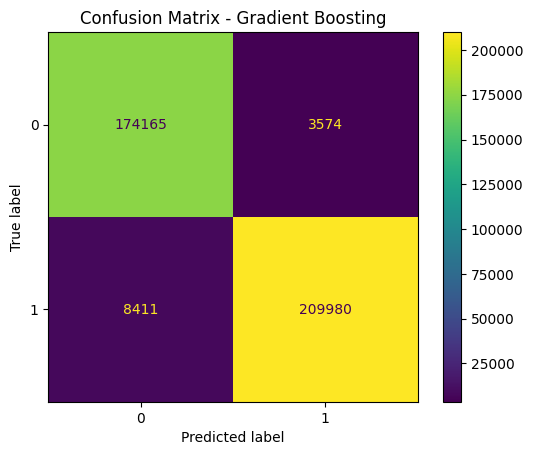

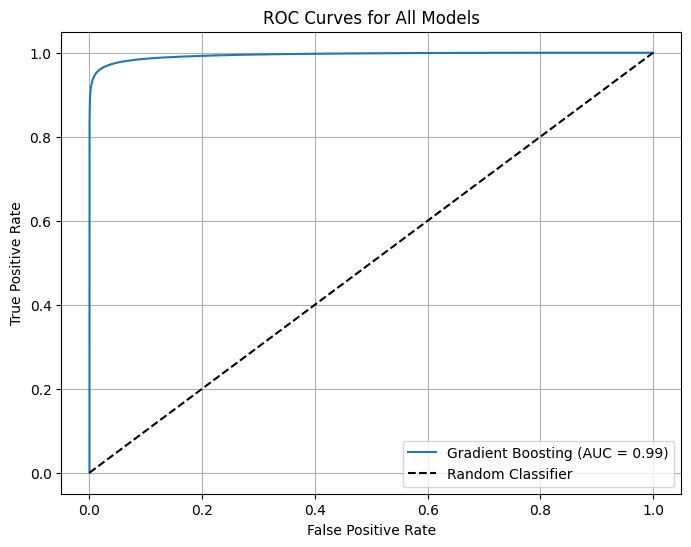


Best models ranked by ROC AUC:
MLP Neural Net: ROC AUC = 0.9984, Log Loss = 0.0408
Random Forest: ROC AUC = 0.9976, Log Loss = 0.0578
Gradient Boosting: ROC AUC = 0.9947, Log Loss = 0.0846
Logistic Regression: ROC AUC = 0.9745, Log Loss = 0.2094

Best model is: MLP Neural Net


In [21]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.metrics import (
    classification_report, accuracy_score, precision_score, recall_score,
    confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, log_loss
)

# Define classifiers
models = {
    'Logistic Regression': LogisticRegression(solver='saga', max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(
        n_estimators=200, max_depth=20, class_weight='balanced', random_state=42, n_jobs=-1),
    'MLP Neural Net': MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=200, random_state=42),
    #'SVM': SVC(probability=True, kernel='rbf', C=1.0, random_state=42)
}

# Dict to store performance metrics
results = {}

# Train and evaluate each model
for name, model in models.items():
    print(f"\n{'='*10} Training {name} {'='*10}")
    model.fit(X_train, y_train)
    
    y_pred = model.predict(X_test)
    y_proba = model.predict_proba(X_test)[:, 1]
    
    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred)
    rec = recall_score(y_test, y_pred)
    roc_auc = roc_auc_score(y_test, y_proba)
    ll = log_loss(y_test, y_proba)
    
    results[name] = {
        'Accuracy': acc,
        'Precision': prec,
        'Recall': rec,
        'ROC AUC': roc_auc,
        'Log Loss': ll,
        'Model': model
    }
    
    print(classification_report(y_test, y_pred))
    print(f"ROC AUC: {roc_auc:.4f}")
    print(f"Log Loss: {ll:.4f}")
    
    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.title(f'Confusion Matrix - {name}')
    plt.show()
    
    # ROC curve
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for All Models")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# Rank models
sorted_models = sorted(results.items(), key=lambda x: x[1]['ROC AUC'], reverse=True)
print("\nBest models ranked by ROC AUC:")
for name, metrics in sorted_models:
    print(f"{name}: ROC AUC = {metrics['ROC AUC']:.4f}, Log Loss = {metrics['Log Loss']:.4f}")

# Pick the best model
best_model_name, best_metrics = sorted_models[0]
best_model = best_metrics['Model']
print(f"\nBest model is: {best_model_name}")


In [22]:
columns =    ['id1','id2','degree_u', 'degree_v',
            'pagerank_u', 'pagerank_v',
            'jaccard',
            'text_similarity',
            'author_overlap',
            'common_neighbors',
            'adamic_adar',
            'abs_degree_diff',
            'abs_pagerank_diff',
            'combined_score',
            'preferential_attachment','label'
            ]

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = columns[:-1]  # Remove the label
print(len(importances))
# Plot
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.bar(range(len(importances)), importances[indices], align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.tight_layout()
plt.show()

AttributeError: 'MLPClassifier' object has no attribute 'feature_importances_'

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


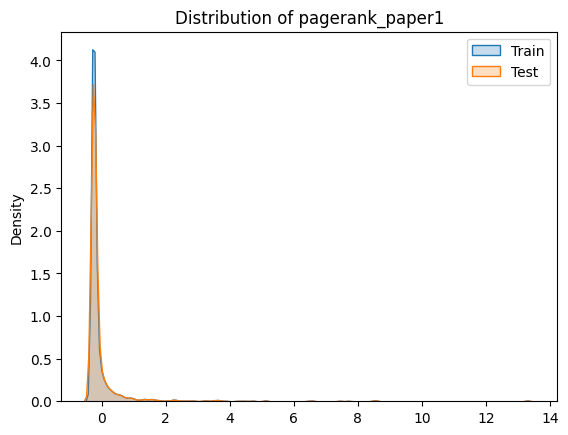

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


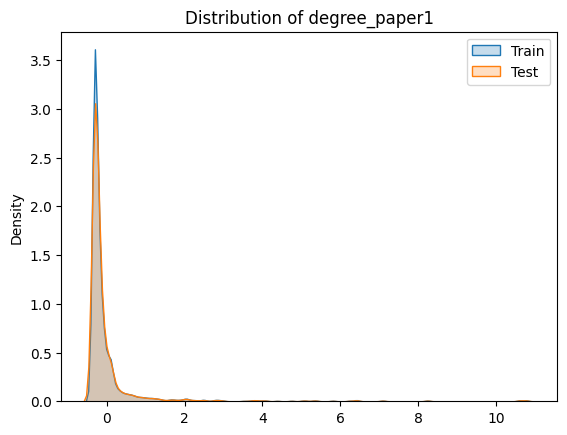

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

X_train = np.array(X_train)
X_test = np.array(X_test)

def plot_feature_drift_array(X_train, X_test, feature_idx, feature_name=None):
    feature_name = feature_name or f"Feature {feature_idx}"
    
    train_feat = X_train[:, feature_idx]
    test_feat = X_test[:, feature_idx]

    sns.kdeplot(train_feat, label='Train', fill=True)
    sns.kdeplot(test_feat, label='Test', fill=True)
    plt.title(f'Distribution of {feature_name}')
    plt.legend()
    plt.show()

plot_feature_drift_array(X_train, X_test, 2, 'pagerank_paper1')
plot_feature_drift_array(X_train, X_test, 0, 'degree_paper1')


# **output probabilities**

In [24]:
import csv
import joblib  # or pickle


# Predict probabilities for the test set
probabilities = model.predict_proba(X_test)[:, 1]  # probability of class 1 (existence)

ids = [i for i in range(len(X_test))]

# Write to CSV file
with open("link_probabilities.csv", "w", newline="") as f:
    writer = csv.writer(f)
    writer.writerow(["ID", "Label"])
    for label, prob in zip(ids, probabilities):
        writer.writerow([label, prob])
